# 默认配置

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from waveforms import cos,sin,gaussian, cosPulse,zero, square
from scipy.signal import savgol_filter,correlate
from scipy.signal import find_peaks
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
from scipy import integrate

from pathlib import Path
import os
import time as TM


In [2]:
def Pulse_wav(waveform = 'cos',envelope = 'cosPulse',samplerate = 2e9,freq = 201e6,time_len = 30e-9,width = 15e-9,repeat = 1,delay =0):
    
    time = np.linspace(0,time_len,int(time_len*samplerate))
    pulse = (eval(f'{waveform}')(2*np.pi*freq))*(eval(f'{envelope}')(width)>>time_len/2)

    wav = zero()
    for i in range(repeat):
        wav += pulse >> (width + delay)*i
    wav >>= 2e-9
    
    return time,wav


def filepath_generate():
    basepath = Path(os.getcwd())/'data'/f'{TM.localtime()[0]}'/(f'{TM.localtime()[1]}'+f'{TM.localtime()[2]}')
    if basepath.exists() is False:
        os.makedirs(basepath)
    return basepath

#  仪器测试

In [ ]:
import time
import pyvisa as visa
import numpy as np

DPOAddress = "TCPIP::192.168.1.78"
rm = visa.ResourceManager()
dpo = rm.open_resource(DPOAddress)

def DSO90254A_readDOPChannel(dpo,
                   channel,
                   period=None,
                   returnTime=False,  #是否返回时间
                   sampleRate=20e9):
    # dpo.query(":STOP; *OPC?")
    # dpo.query(":ADER?")
    # dpo.write(":SINGle")
    dpo.write(f":WAVeform:SOURce CHAN{channel}")
    data = dpo.query(":WAVeform:DATA?")
    data = np.array([float(s) for s in data.split(',')[:-1]])
    if period is not None:
        periodPointNum = int(period * sampleRate)
        n = len(data) // periodPointNum
        data = data[:n * periodPointNum].reshape(n,
                                                 periodPointNum).mean(axis=0)
    if returnTime:
        return np.arange(len(data)) / sampleRate, data
    else:
        return data
    
readDOPChannel = DSO90254A_readDOPChannel  

print(dpo.query('*Idn?'))

# DAC

## 波形生成

179


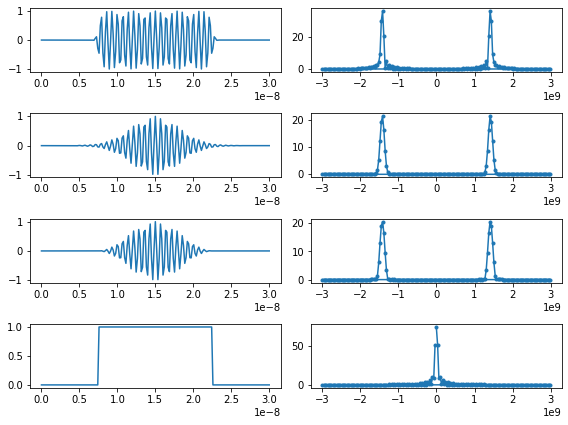

In [3]:
samplerate = 6e9

time_len = 30e-9
width = 15e-9
freq = 1400e6
time = np.linspace(0,time_len,int(time_len*samplerate))

wav1 = (cos(2*np.pi*freq))*(square(width,edge=2e-9)>>time_len/2)
wav2 = (cos(2*np.pi*freq))*(gaussian(width)>>time_len/2)
#t3,wav3 = Pulse_wav(envelope= 'cosPulse', width = width, freq=freq, time_len= time_len)
wav3 = (cos(2*np.pi*freq))*(cosPulse(width)>>time_len/2)
# t3,wav3 = Pulse_wav(waveform = 'cos',samplerate = samplerate,freq = freq,time_len = time_len ,width = width,repeat = 1)

wav4 = (square(width)>>time_len/2)


print(len(wav1(time)))
fig,axs = plt.subplots(4,2,figsize=(8, 6))
# axs = axs.flatten()
for i in range(4):
    axs[i][0].plot(time,eval(f'wav{i+1}(time)'))
    fft_freq = np.fft.fftfreq(int(time_len*samplerate),1/samplerate)
    axs[i][1].plot(fft_freq,np.abs(np.fft.fft(np.hamming(int(time_len*samplerate))*(eval(f'wav{i+1}(time)')))),'.-')
fig.tight_layout()

## 设备配置

### 连接设备

In [4]:
import NS_MCI
driver = NS_MCI.Driver('192.168.1.194', timeout=10)
driver.open()
# driver.set('MixMode',1)
# driver.write('RefClock','out')

指令初始化执行成功
指令DAC配置执行成功
指令ADC配置执行成功


In [5]:
driver.write('Waveform', wav3(time), channel=8)  # 命令， 波形， 通道
driver.write('Waveform', wav4(time), channel=7)
driver.write('AWG', {'period': 1e7 , 'count': 100000})


指令DAC数据更新执行成功
指令DAC数据更新执行成功
指令内部PRF产生执行成功


### DPO获取分析

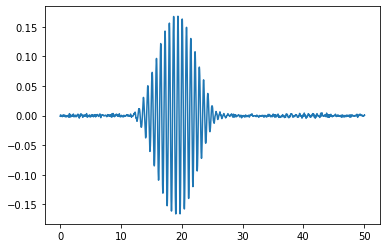

In [7]:
y = []
for i in range(5):
    t, y1 = readDOPChannel(dpo, 1,returnTime=True, sampleRate=320e9)
    y.append(y1)

y =  np.mean(y,axis=0)
y.shape
plt.figure()
plt.plot(t/1E-9, y1)

In [7]:
time,wav = Pulse_wav(samplerate = 6e9,freq = 1400e6, time_len = 15e-9,width = 15e-9,repeat = 1)
wav = (wav+1)/2

In [8]:
%matplotlib notebook

plt.figure(figsize=(8, 6))
plt.subplot(221)
ch = 8
maxValue = np.max(y)
minValue = np.min(y)
normlized_y = (y - minValue) / (maxValue - minValue)

plt.plot(t / 1e-9,
         normlized_y,
         label=f'max = {maxValue:.5f}\nmin = {minValue:.5f}')
plt.title('DDS_waveform')
plt.xlabel('time (ns)')
plt.ylabel('amp ')
plt.legend(loc=1)
plt.grid(visible=True, which='both', axis='both')

# plt.plot(t / 1e-9,wav(t),'-g',alpha = 0.4,label='origin')
temp = correlate(wav(t),normlized_y,mode='same',method='fft')
temp1 = [np.correlate((wav>>temp_t)(t),normlized_y) for temp_t in t]
align_t2 = t[np.argmax(temp1)]

# func = interp1d(np.arange(len(t)),temp,kind='cubic')
# smooth_t = np.linspace(0,len(t)-1,20001)
# smooth_y = savgol_filter(func(smooth_t),window_length=41, polyorder=3)

# align_t = t[int(smooth_t[np.argmax(smooth_y)])]-2*9.5e-9
# print(0.5*(t[0]+t[-1]))

new_wav = wav >> align_t2
plt.plot(t / 1e-9,new_wav(t),'-r',alpha = 0.4,label='align')
plt.show()
# plt.legend()

data_corr = correlate(new_wav(t),normlized_y,mode='same',method='fft')
data_corr /= np.sqrt(
    np.correlate(normlized_y, normlized_y)[0] *
    np.correlate(new_wav(t), new_wav(t))[0])
max_corr = np.max(data_corr)

plt.subplot(222)
f = interp1d(t,y**2/50,kind='linear')
value,_ = integrate.quad(f,t[0],t[-1])
freq = np.fft.fftfreq(len(t),t[1]-t[0])[:len(t)//2]
data = np.fft.fft(np.correlate(y,y,'same'))[:len(t)//2]

data = np.fft.fft(y)[:len(t)//2]
data = np.abs(data)**2/50
data = value*30e6*data/np.sum(data)
power = 10*np.log10(data/1e-3)

peak_freq = freq[np.argmax(power)]
peak_power = np.max(power)
plt.plot(freq,power,'.-')
plt.plot(peak_freq,peak_power,'*',label = f'power={peak_power:.2f}dBm\nfreq={peak_freq/1e9:.4f}GHz')
plt.title('Power_Spectrum_Density')
plt.xlabel('freq (Hz)')
plt.ylabel('Power (dBm)')
plt.legend()


plt.subplot(223)
plt.plot(t,data_corr,'-',label =f'max_corr_err = {1-max_corr:.4e}')
plt.title('PGAWG $R^2$')
plt.xlabel('time (ns)')
plt.ylabel('correlated coefficient ')
plt.legend()




plt.subplot(224)
diff_data =  normlized_y - new_wav(t)

plt.plot(t/1e-9,diff_data,'.-',label='diff_data')
plt.hlines(0.01,0,50,colors="red",label='1% line')
start_time = np.where(np.abs(diff_data)>=0.005)[0][0]
end_time = np.where(np.abs(diff_data)>=0.005)[0][-1]
plt.vlines(t[start_time]/1e-9,np.min(diff_data),np.max(diff_data),colors="green",label=f'start = {t[start_time]/1e-9:.1f}ns')
plt.vlines(t[end_time]/1e-9,np.min(diff_data),np.max(diff_data),colors="green",label=f'end = {t[end_time]/1e-9:.1f}ns')
plt.title('diff_data')
plt.xlabel('time (ns)')
plt.grid(visible=True, which='both', axis='both')
plt.legend(loc=4)
plt.show()
plt.tight_layout()

basepath = filepath_generate()
plt.savefig(basepath / f'RFsoc_DDS_cos_ch{ch}_{int(TM.time())}')
np.savez(basepath / f'RFsoc_DDS_cos_ch{ch}_{int(TM.time())}',
         t=t,
         data=y,
         waveform=new_wav)

<IPython.core.display.Javascript object>

NameError: name 'y' is not defined

# ADC

## 波形生成及处理

In [6]:
def coff_para(t=[],freq=200e6):
    coeff_list_I = np.array(cos(2*np.pi*(freq))(t))
    coeff_list_Q = np.array(sin(2*np.pi*(freq))(t))
    return coeff_list_I+1j*coeff_list_Q

def getTraceIQ(y,coff_para=np.asarray([])):
    return  np.abs(y).dot(coff_para.T)/len(y)


## ADC配置

In [7]:
import NS_MCI
driver = NS_MCI.Driver('192.168.1.194', timeout=10)
driver.open()
# driver.write('RefClock','')
# driver.set('MixMode',1)
# driver.write('RefClock','in')

指令初始化执行成功
指令DAC配置执行成功
指令ADC配置执行成功


In [44]:
freq1 = 1400e6
freq2 = 1300e6

diff = 0.8e6

samplerate = 6e9
time_len = 30e-9

shots = 100
runtime = 512e-9  # ns

wav = cos(2*np.pi*(freq1 + diff)) + cos(2*np.pi*(freq2+diff))
time = np.linspace(0,runtime,int(runtime*4*samplerate))
plt.plot(wav(time))

In [45]:

for i in range(8):
    driver.write('PointNumber', runtime * 1e9, channel=i+1)
    driver.write('TriggerDelay', 2048, channel=i+1)

driver.write('Waveform', wav(time), channel=1)  # 命令， 波形， 通道
    
driver.write('AWG', {'period': 1e7 , 'count': shots})


指令ADC配置执行成功
指令ADC配置执行成功
指令ADC配置执行成功
指令ADC配置执行成功
指令ADC配置执行成功
指令ADC配置执行成功
指令ADC配置执行成功
指令ADC配置执行成功
指令ADC配置执行成功
指令ADC配置执行成功
指令ADC配置执行成功
指令ADC配置执行成功
指令ADC配置执行成功
指令ADC配置执行成功
指令ADC配置执行成功
指令ADC配置执行成功
指令DAC数据更新执行成功
指令内部PRF产生执行成功


应获取数据量： 3481600.0
100


<IPython.core.display.Javascript object>


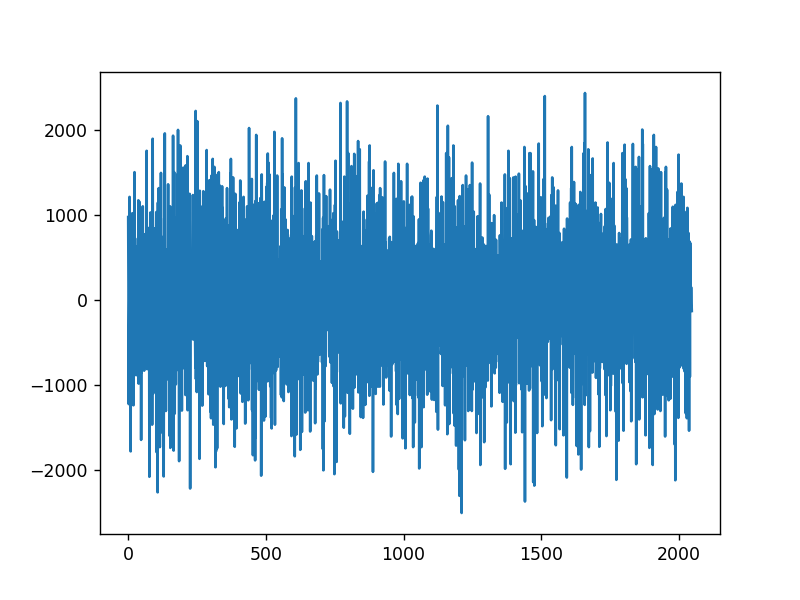

(100, 2048)

In [46]:
%matplotlib notebook
print('应获取数据量：', (runtime * 4e9 * 2 +256) * 8 * shots)
tmp = driver.read('TraceIQ', channel=1)
print(len(tmp))
# np.save('./adc_data.npy',tmp)
plt.figure()
plt.plot(tmp[0])
tmp.shape

In [29]:

driver.PointNumber

2048

In [30]:
driver.set('Freqlist',[freq1, freq2],1)
#print(driver.Freqlist)
print(len(driver.Cofflist[0][0]))


指令量子解调配置执行成功
2048


In [31]:
driver.Cofflist

{0: [array([ 1.00000000e+00+6.12323400e-17j, -5.87785252e-01+8.09016994e-01j,
         -3.09016994e-01-9.51056516e-01j, ...,
         -1.41557409e-13-1.00000000e+00j,  8.09016994e-01+5.87785252e-01j,
         -9.51056516e-01+3.09016994e-01j]),
  array([ 1.        +6.12323400e-17j, -0.4539905 +8.91006524e-01j,
         -0.58778525-8.09016994e-01j, ..., -0.70710678-7.07106781e-01j,
          0.95105652-3.09016994e-01j, -0.15643447+9.87688341e-01j])],
 1: [],
 2: [],
 3: [],
 4: [],
 5: [],
 6: [],
 7: []}

In [32]:
tmp = driver.read('SIQ', channel=1)

In [33]:
len(tmp[0])

100

<IPython.core.display.Javascript object>


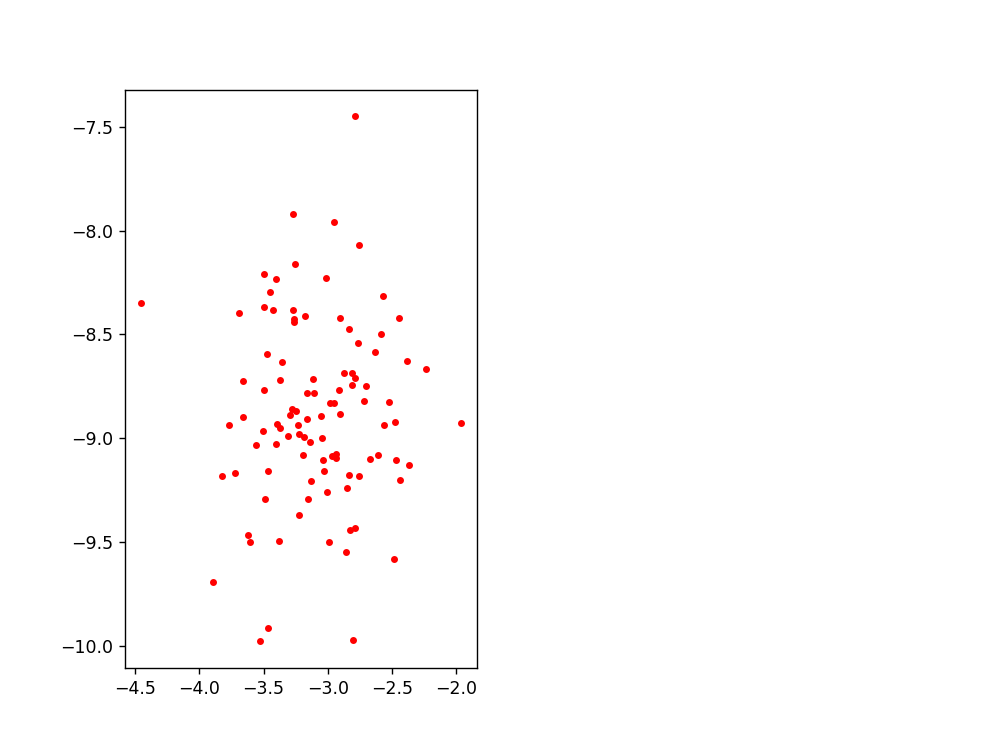

ValueError: x and y must have same first dimension, but have shapes (0,) and (100,)

In [34]:
plt.figure(figsize=(8,6))
plt.subplot(121)
plt.plot(np.real(tmp[0][0:100]),np.imag(tmp[0][0:100]), '.', color = 'r')
plt.plot(np.real(tmp[0][100:200]),np.imag(tmp[0][0:100]), '.', color = 'b')

plt.show()
plt.subplot(122)
plt.plot(np.real(tmp[1][0:100]),np.imag(tmp[1][0:100]), '.', color = 'r')
plt.plot(np.real(tmp[1][100:200]),np.imag(tmp[1][0:100]), '.', color = 'b')
plt.show()

# 设备复位

In [ ]:
# driver.set('Reset',0)

In [17]:
driver.close()

Info: 参数保存成功
